# RNN 개념이해

* 서울의 주간평균기온 데이터를 이용하여 RNN 모델을 구현해 봅시다.

## 1.환경 준비

### (1) 라이브러리 로딩

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM, Flatten, Input
from keras.backend import clear_session
from tensorflow.keras.optimizers import Adam

### (2) 필요한 함수 생성

* 학습곡선 함수

In [ ]:
# 학습곡선 함수
def dl_history_plot(history):
    plt.figure(figsize=(10,6))
    plt.plot(history['loss'], label='train_err', marker = '.')
    plt.plot(history['val_loss'], label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

* 데이터 2 --> 3차원 변환

In [ ]:
# 시계열 데이터 전처리 2차원 --> 3차원으로 변환
def temporalize(x, y, timesteps):
    nfeature = x.shape[1]
    output_x = []
    output_y = []
    for i in range(len(x) - timesteps + 1):
        t = []
        for j in range(timesteps):
            t.append(x[[(i + j)], :])
        output_x.append(t)
        output_y.append(y[i + timesteps - 1])
    return np.array(output_x).reshape(-1,timesteps, nfeature), np.array(output_y)

### (3) Data Loading

In [ ]:
data = pd.read_csv('https://raw.githubusercontent.com/DA4BAM/dataset/master/temperature.csv')
data.head(10)

,year,week,AvgTemp
0,2010,1,-3.000000
1,2010,2,-7.500000
2,2010,3,-7.900000
3,2010,4,-2.357143
4,2010,5,-3.342857
5,2010,6,-1.800000
6,2010,7,-0.314286
7,2010,8,-2.142857
8,2010,9,4.400000
9,2010,10,7.057143


## 2.데이터 이해

온도의 흐름(trend)을 살펴봅시다.

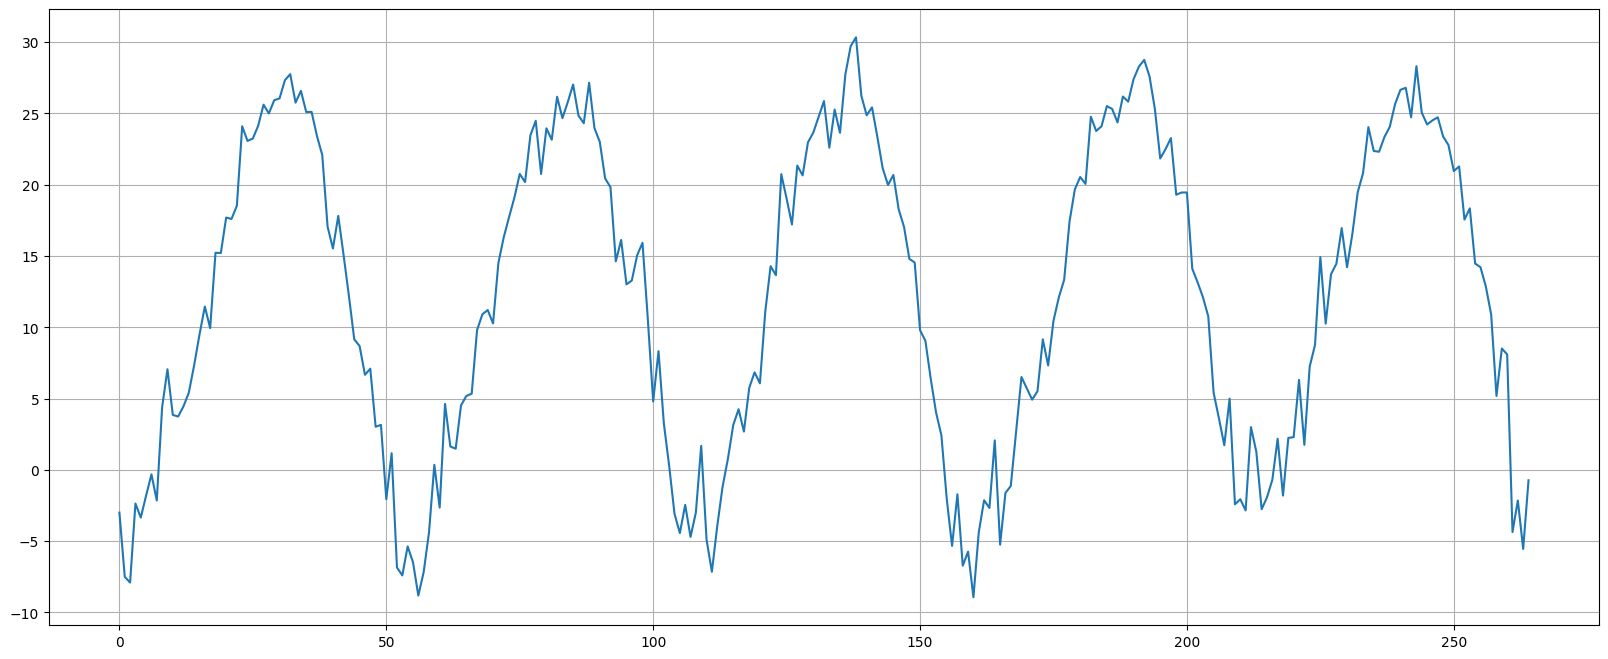

In [ ]:
plt.figure(figsize = (20,8))
plt.plot(data.AvgTemp)
plt.grid()
plt.show()

## 3.데이터 준비

### (1) y 만들기

In [ ]:
data['y'] = data['AvgTemp'].shift(-1)
data.dropna(axis = 0, inplace = True)
data.head()

,year,week,AvgTemp,y
0,2010,1,-3.000000,-7.500000
1,2010,2,-7.500000,-7.900000
2,2010,3,-7.900000,-2.357143
3,2010,4,-2.357143,-3.342857
4,2010,5,-3.342857,-1.800000


### (2) x, y 분리

In [ ]:
x = data.loc[:, ['AvgTemp']]
y = data.loc[:,'y']

### (3) 스케일링

In [ ]:
scaler = MinMaxScaler()
x = scaler.fit_transform(x)

In [ ]:
x.shape, y.shape

((264, 1), (264,))

### (4) 3차원 구조 만들기

In [ ]:
x2, y2 = temporalize(x, y, 4)
x2.shape, y2.shape

((261, 4, 1), (261,))

In [ ]:
x2[:2]

array([[[0.15106693],
        [0.0364937 ],
        [0.02630941],
        [0.16743453]],

       [[0.0364937 ],
        [0.02630941],
        [0.16743453],
        [0.14233754]]])

In [ ]:
y[:7], y2[:2]

(0   -7.500000
 1   -7.900000
 2   -2.357143
 3   -3.342857
 4   -1.800000
 5   -0.314286
 6   -2.142857
 Name: y, dtype: float64,
 array([-3.34285714, -1.8       ]))

### (5) 데이터 분할

* shuffle = False : 섞지 마라.(랜덤 분할 하지 마라)
* test_size= 53 :
    * 소수 : 비율
    * 자연수 : 개수

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x2, y2, test_size= 53, shuffle = False)

In [ ]:
x_train.shape, y_train.shape

((208, 4, 1), (208,))

In [ ]:
x_val.shape, y_val.shape

((53, 4, 1), (53,))

## 4.RNN : 무작정 모델링

### (1) 입력 구조(shape)
* 분석 단위 : 2차원 ( timesteps, nfeatures)

In [ ]:
x_train.shape

(208, 4, 1)

In [ ]:
timesteps = x_train.shape[1]
nfeatures = x_train.shape[2]

### (2) 모델 구조 설계
* 다음 구조를 그대로 설계해 봅시다.
    * SimpleRNN(8, input_shape = (timesteps, nfeatures))
    * Dense(1)

In [ ]:
clear_session()

model = Sequential([Input(shape = (timesteps, nfeatures)),
                    SimpleRNN(8),
                    Dense(1)])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)               │ (None, 8)                   │              80 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 89 (356.00 B)

 Trainable params: 89 (356.00 B)

 Non-trainable params: 0 (0.00 B)

### (3) 컴파일 및 학습
* 다음 조건으로 학습해 봅시다.
    * epochs = 100
    * learning_rate = 0.01

In [ ]:
model.compile(optimizer = Adam(learning_rate = 0.01), loss = 'mse' )
history = model.fit(x_train, y_train, epochs = 100, validation_split = .2).history

Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - loss: 261.5599 - val_loss: 313.2922
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 239.1240 - val_loss: 285.5439
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 202.0459 - val_loss: 263.7328
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 198.4003 - val_loss: 245.5482
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 191.9767 - val_loss: 229.8910
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 192.4814 - val_loss: 215.9823
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 165.2865 - val_loss: 203.6915
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 165.2082 - val_loss: 192.4701
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 166.6418 - val_loss: 182.5930
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 152.3006 - val_loss: 174.1292
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 135.4707 - val_loss: 166.8962
Epoch 12/100
6/6 ━━━━━━━━━━━━━━━

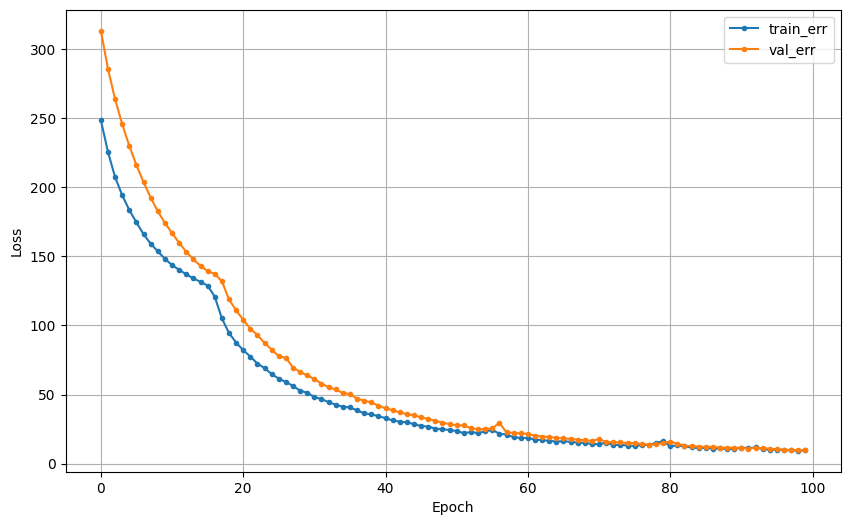

In [ ]:
# 학습 곡선을 그려봅시다.
dl_history_plot(history)

### (4) 예측 및 평가

In [ ]:
# 예측
pred = model.predict(x_val)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


In [ ]:
# 평가
print(mean_absolute_error(y_val, pred))
print(mean_absolute_percentage_error(y_val, pred))

2.805320396520593
0.6211079235969166


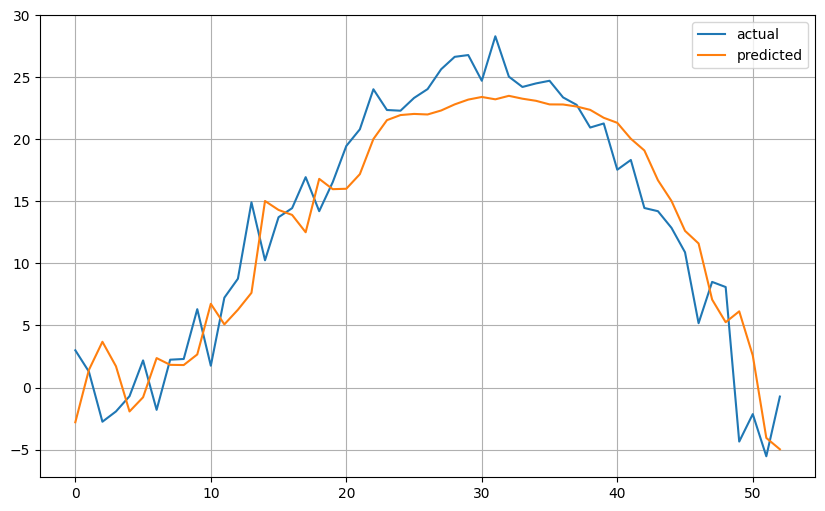

In [ ]:
plt.figure(figsize = (10,6))
plt.plot(y_val, label = 'actual')
plt.plot(pred, label = 'predicted')
plt.legend()
plt.grid()
plt.show()

## 5.RNN 모델링②

### (1) 입력 구조(shape)
* 분석 단위 : 2차원 ( timesteps, nfeatures)

In [ ]:
timesteps = x_train.shape[1]
nfeatures = x_train.shape[2]

### (2) 모델 구조 설계
* 이제 RNN 레이어를 추가해 봅시다.
    * SimpleRNN(8, input_shape = (timestep, nfeatures), return_sequences = True)
    * SimpleRNN(8)
    * Dense(1)

In [ ]:
clear_session()

model = Sequential([Input(shape = (timesteps, nfeatures)),
                    SimpleRNN(8, return_sequences = True),
                    SimpleRNN(4),
                    Dense(1)])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)               │ (None, 4, 8)                │              80 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_1 (SimpleRNN)             │ (None, 4)                   │              52 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │               5 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 137 (548.00 B)

 Trainable params: 137 (548.00 B)

 Non-trainable params: 0 (0.00 B)

### (3) 컴파일 및 학습
* 다음 조건으로 학습해 봅시다.
    * epochs = 200
    * learning_rate = 0.01

In [ ]:
model.compile(optimizer = Adam(learning_rate = 0.01), loss = 'mse' )
history = model.fit(x_train, y_train, epochs = 200, validation_split = .2).history

Epoch 1/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 247.3384 - val_loss: 293.5876
Epoch 2/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 227.1888 - val_loss: 274.5263
Epoch 3/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 207.4173 - val_loss: 262.3050
Epoch 4/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 201.0859 - val_loss: 252.3176
Epoch 5/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 196.6597 - val_loss: 243.8787
Epoch 6/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 178.1640 - val_loss: 236.2359
Epoch 7/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 189.3115 - val_loss: 228.8601
Epoch 8/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 179.8207 - val_loss: 222.0818
Epoch 9/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 173.3493 - val_loss: 215.6677
Epoch 10/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 164.7522 - val_loss: 209.5786
Epoch 11/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 163.5651 - val_loss: 203.6391
Epoch 12/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s

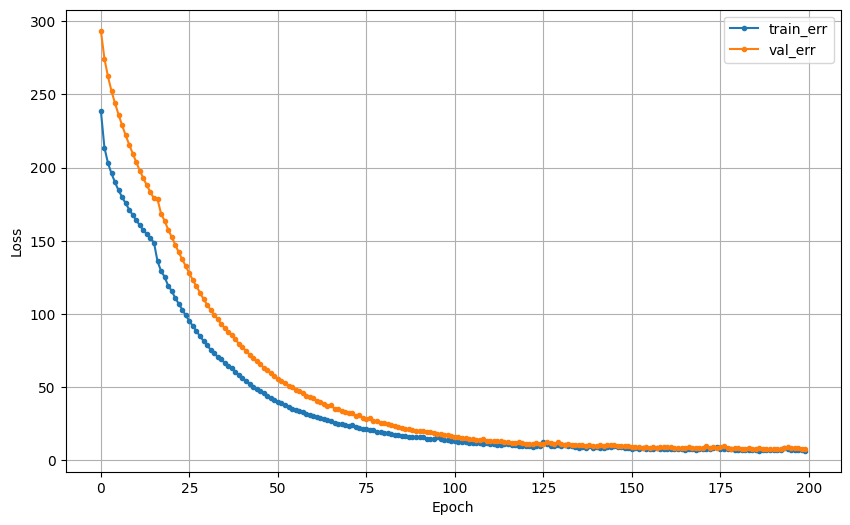

In [ ]:
# 학습 곡선을 그려봅시다.
dl_history_plot(history)

### (4) 예측 및 평가

In [ ]:
# 예측
pred = model.predict(x_val)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


In [ ]:
# 평가
print(mean_absolute_error(y_val, pred))
print(mean_absolute_percentage_error(y_val, pred))

2.482223029195708
0.641830770509934


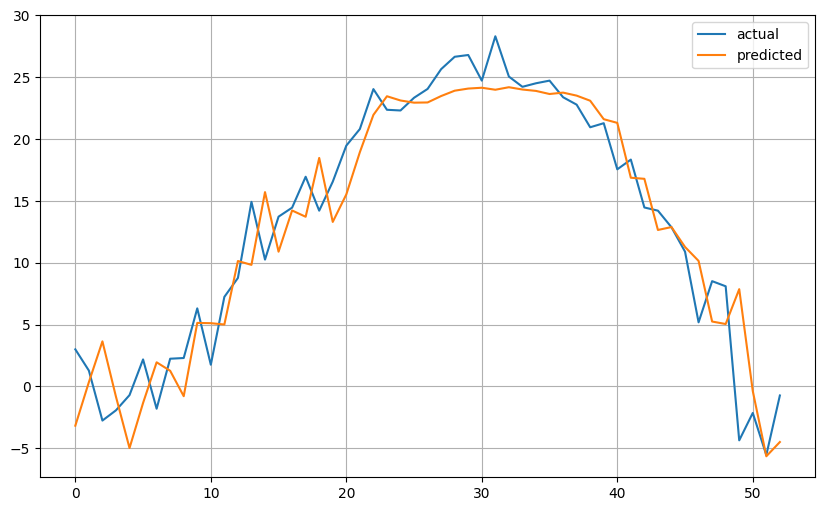

In [ ]:
plt.figure(figsize = (10,6))
plt.plot(y_val, label = 'actual')
plt.plot(pred, label = 'predicted')
plt.legend()
plt.grid()
plt.show()

## 6.LSTM 모델링
* 5번 모델의 SimpleRNN을 LSTM 로 이름만 바꿔봅시다.

### (1) 데이터 준비

* timestep

In [ ]:
timesteps = 14
x2, y2 = temporalize(x, y, timesteps)
x2.shape, y2.shape

((251, 14, 1), (251,))

* 데이터 분할

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x2, y2, test_size= 53, shuffle = False)

### (2) 입력 구조(shape)
* 분석 단위 : 2차원 ( timesteps, nfeatures)

In [ ]:
timesteps = x_train.shape[1]
nfeatures = x_train.shape[2]

### (3) 모델 구조 설계


In [ ]:
clear_session()

model = Sequential([Input(shape = (timesteps, nfeatures)),
                    LSTM(8, return_sequences = True),
                    LSTM(8),
                    Dense(1)])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 14, 8)               │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 8)                   │             544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 873 (3.41 KB)

 Trainable params: 873 (3.41 KB)

 Non-trainable params: 0 (0.00 B)

### (4) 컴파일 및 학습

In [ ]:
model.compile(optimizer = Adam(learning_rate = 0.01), loss = 'mse' )
history = model.fit(x_train, y_train, epochs = 200, validation_split = .2).history

Epoch 1/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - loss: 246.6954 - val_loss: 333.0058
Epoch 2/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 261.1093 - val_loss: 310.8845
Epoch 3/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 240.8468 - val_loss: 288.5889
Epoch 4/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 235.5317 - val_loss: 266.3983
Epoch 5/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 189.9647 - val_loss: 248.8244
Epoch 6/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 198.0111 - val_loss: 234.5926
Epoch 7/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 174.1457 - val_loss: 222.9153
Epoch 8/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 177.7096 - val_loss: 212.5097
Epoch 9/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 165.0871 - val_loss: 203.2757
Epoch 10/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 164.2765 - val_loss: 194.7077
Epoch 11/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 161.0247 - val_loss: 186.7477
Epoch 12/200
5/5 ━━━━━━━━━━━━━

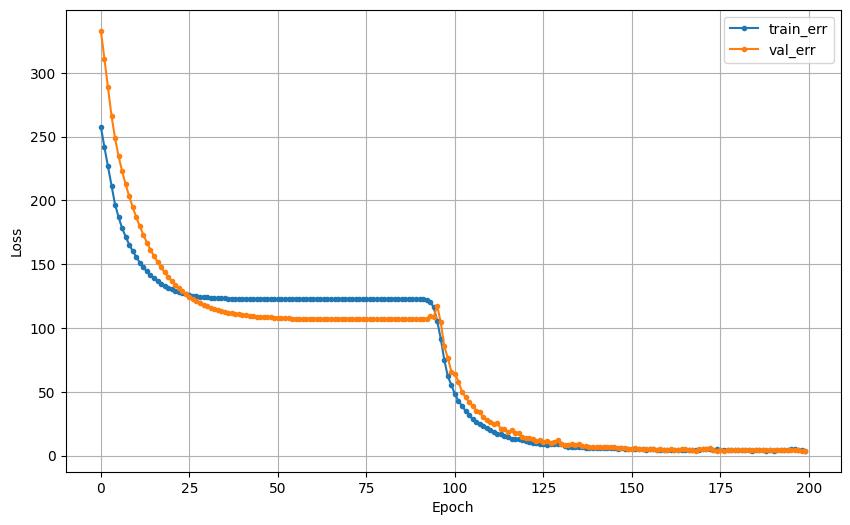

In [ ]:
dl_history_plot(history)

### (5) 예측 및 평가

In [ ]:
# 예측
pred = model.predict(x_val)

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


In [ ]:
# 평가
print(mean_absolute_error(y_val, pred))
print(mean_absolute_percentage_error(y_val, pred))

2.320093724976457
0.6728699605058415


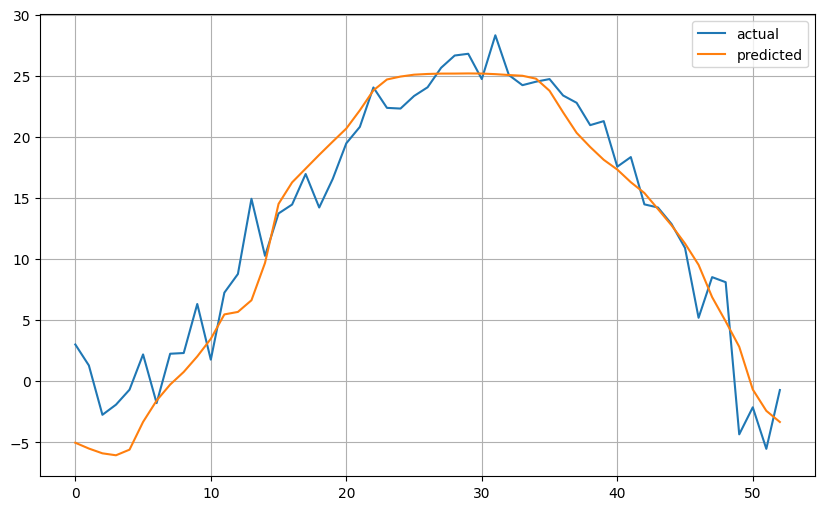

In [ ]:
plt.figure(figsize = (10,6))
plt.plot(y_val, label = 'actual')
plt.plot(pred, label = 'predicted')
plt.legend()
plt.grid()
plt.show()

## 7.자유롭게 모델링~!
* 다음 항목을 조정하며 모델링을 수행해 봅시다.
    * timestep
    * 레이어와 노드수
    * learning_rate, epochs


### (1) 데이터 준비

* timestep

In [ ]:
timesteps =  10   # <- timestep 수 지정
x2, y2 = temporalize(x, y, timesteps)
x2.shape, y2.shape

((255, 10, 1), (255,))

* 데이터 분할

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x2, y2, test_size= 53, shuffle = False)

### (2) 입력 구조(shape)
* 분석 단위 : 2차원 ( timesteps, nfeatures)

In [ ]:
timesteps = x_train.shape[1]
nfeatures = x_train.shape[2]

### (3) 모델 구조 설계


### (4) 컴파일 및 학습

### (5) 예측 및 평가